<a href="https://colab.research.google.com/github/Naveenchode/Covid19/blob/main/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [16]:
#100 (covid + normal)
!unzip /content/gdrive/MyDrive/CovidDataset.zip

Archive:  /content/gdrive/MyDrive/CovidDataset.zip
   creating: cov/Train/
   creating: cov/Train/covid/
  inflating: cov/Train/covid/001.jpeg  
  inflating: cov/Train/covid/002.jpeg  
  inflating: cov/Train/covid/003.jpeg  
  inflating: cov/Train/covid/004.jpeg  
  inflating: cov/Train/covid/005.jpeg  
  inflating: cov/Train/covid/006.jpeg  
  inflating: cov/Train/covid/007.jpg  
  inflating: cov/Train/covid/008.jpg  
  inflating: cov/Train/covid/009.jpg  
  inflating: cov/Train/covid/010.jpeg  
  inflating: cov/Train/covid/011.jpeg  
  inflating: cov/Train/covid/012.jpeg  
  inflating: cov/Train/covid/013.jpeg  
  inflating: cov/Train/covid/014.jpeg  
  inflating: cov/Train/covid/015.jpeg  
  inflating: cov/Train/covid/016.jpeg  
  inflating: cov/Train/covid/017.jpeg  
  inflating: cov/Train/covid/018.jpeg  
  inflating: cov/Train/covid/019.jpeg  
  inflating: cov/Train/covid/01E392EE-69F9-4E33-BFCE-E5C968654078-768x572.jpeg  
  inflating: cov/Train/covid/020.jpg  
  inflating: cov/T

In [3]:
pip install keras


In [4]:
pip install livelossplot

In [5]:
import keras
from keras import layers
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from livelossplot import PlotLossesKeras
import tensorflow as tf


In [14]:
TRAINING_LOGS_FILE = "training_logs.csv"
MODEL_SUMMARY_FILE = "model_summary.txt"
MODEL_FILE = "model.h5"

In [12]:
IMAGE_SIZE = 224
IMAGE_WIDTH, IMAGE_HEIGHT = IMAGE_SIZE, IMAGE_SIZE
EPOCHS =10
BATCH_SIZE =2
TEST_SIZE = 2
learning = 0.00001
input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3)

In [13]:
#VGG19 - Pretrained
#from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import numpy as np
%matplotlib inline

base_model=tf.keras.applications.vgg19.VGG19(weights='imagenet',include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(lr=learning, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='categorical_crossentropy',metrics=['accuracy'])

import warnings
warnings.filterwarnings("ignore")

model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [17]:
with open(MODEL_SUMMARY_FILE,"w") as fh:
    model.summary(print_fn=lambda line: fh.write(line + "\n"))

training_data_generator = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)
validation_data_generator = ImageDataGenerator(rescale=1./255)
test_data_generator = ImageDataGenerator(rescale=1./255)

In [18]:
# Data 
training_data_dir ="/content/cov/Train" # 4000
validation_data_dir = "/content/cov/Val" # 600

In [19]:
training_generator = training_data_generator.flow_from_directory(
    training_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical")
validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)


Found 3963 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


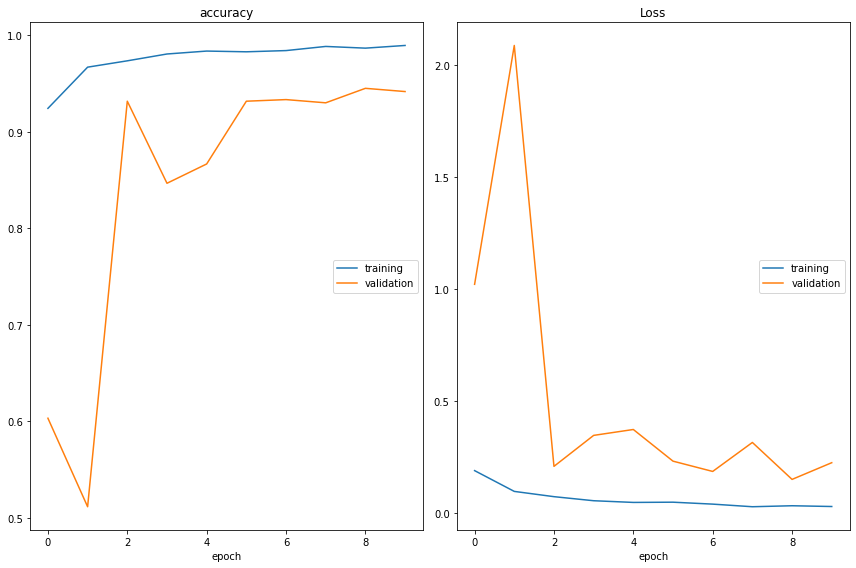

accuracy
	training         	 (min:    0.924, max:    0.989, cur:    0.989)
	validation       	 (min:    0.512, max:    0.945, cur:    0.942)
Loss
	training         	 (min:    0.029, max:    0.190, cur:    0.030)
	validation       	 (min:    0.151, max:    2.088, cur:    0.226)


In [20]:
import warnings
warnings.filterwarnings("ignore")

# Training
H = model.fit_generator(
    training_generator,
    steps_per_epoch=len(training_generator.filenames) // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validation_generator.filenames) // BATCH_SIZE,
    callbacks=[PlotLossesKeras(), CSVLogger(TRAINING_LOGS_FILE,
                                            append=False,
                                            separator=";")], 
    verbose=1)

#model.save_weights(MODEL_FILE)

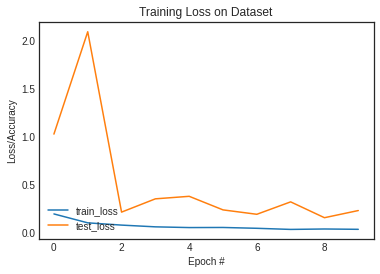

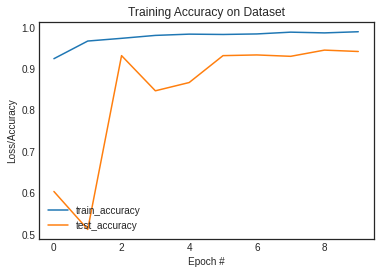

In [21]:
N = EPOCHS
plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

plt.style.use("seaborn-white")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="test_accuracy")
plt.title("Training Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

Found 600 images belonging to 2 classes.
Confusion Matrix


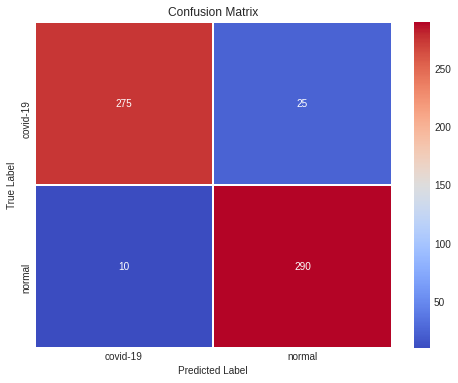

[[275  25]
 [ 10 290]]
Classification Report
              precision    recall  f1-score   support

    covid-19       0.96      0.92      0.94       300
      normal       0.92      0.97      0.94       300

    accuracy                           0.94       600
   macro avg       0.94      0.94      0.94       600
weighted avg       0.94      0.94      0.94       600



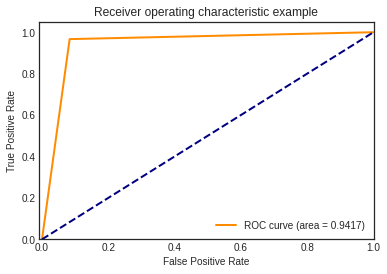

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

LABELS = ["covid-19","normal"]

def show_confusion_matrix(validations, predictions):
    matrix = confusion_matrix(validations, predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(matrix,
                cmap="coolwarm",
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt="d")
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

validation_generator = validation_data_generator.flow_from_directory(
    validation_data_dir,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False)    

filenames = validation_generator.filenames
nb_samples = len(filenames)

Y_pred = model.predict_generator(validation_generator,(nb_samples//BATCH_SIZE))
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
show_confusion_matrix(validation_generator.classes, y_pred)
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ["covid-19","normal"]
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))
# Plot linewidth.
lw = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
   fpr[i], tpr[i], _ = roc_curve(validation_generator.classes, y_pred)
   roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
       lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()